- Finding centers of similarity using the popular **k-means** algorithm;
- Taking a bottom-up approach to building hierarchical clustering trees;
- Identifying arbitrary shapes of objects using a density-based clustering approach.

# Grouping objects by similarity using k-means

Clustering is a technique that allows us to find groups of similar objects that are more related to each other than to objects in other groups. Examples of business-oriented applications of clustering include the grouping of documents, music and movies by different topics, or finding customers that share similar interests based on common purchase behaviours as a basis for recommendation engines.

## K-means clustering

This algorithm is extremely easy to implement while also beeing computationally very efficient compared to other clustering algorithms. K-means clustering belongs to the category of prototype-based clustering.

There are other two categories, that are hierarchical and density-based clustering.

Prototype-based means that each cluster is represented by a prototype, which is usually either the **centroid** (average) of similar points in case of continuous features, or the **medoid** (the most representative or the point that minimizes the distance to all other points that belong to a particular cluster) in case of categorical features.

It's really good at identifying clusters with a spherical shape, but it needs a user-specified hyperparameter $k$ to determine the number of clusters *a priori*. We'll see methods to evaluate the quality of a clustering to determine the optimal number of clusters.

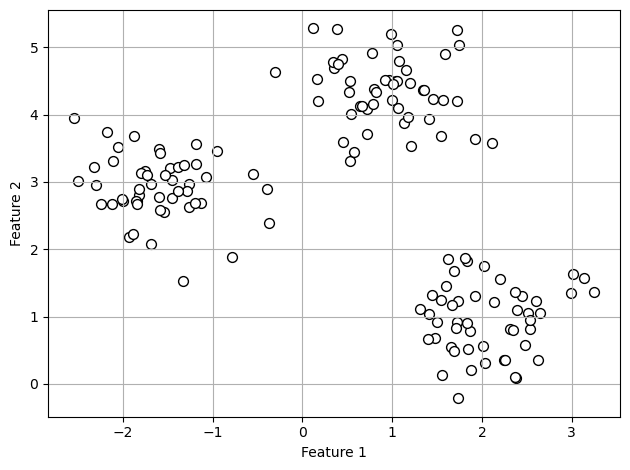

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,n_features=2,centers=3,cluster_std=0.5,shuffle=True,random_state=0)

import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c='white',marker='o',edgecolors='black',s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.tight_layout()
plt.show()

Our goal now is to group the examples based on their feature similarities, which can be achieved using the k-means algorithm, as summerized here in the following steps:
1. Randomly pick $k$ centroids from the examples as initial cluster centers;
2. Assign each example to the nearest centroid $\mu^j, j\in{1,...,k}$;
3. Move the centroids to the center of the examples that were assigned to it;
4. Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined tolerance or maximum number of iterations is reached.

We can define the similarity as the opposite of distance, and a common distance for clustering examples with continuous features is the squared euclidean distance:
$$d(x,y)^2 = \sum_{j=1}^m(x_j-y_j)^2=\Vert x-y\Vert_2^2$$

Base on this Euclidean distance metric, we can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster sum of squared errors (SSE), which is sometimes also called cluster inertia:
$$SSE=\sum_{i=1}^n\sum_{j=1}^kw^{(i,j)}\Vert x^{(i)}-\mu^{(j)}\Vert_2^2$$
Here:
- $\mu_j$ represents the centroid for the cluster $j$;
- $w^{(i,j)}=0$ if the example $x^{(i)}$ is in the cluster $j$.

In [8]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=3,
    init='random',
    n_init=10, # the algorithm will be runned 10 times indipendently, with different random centroids
    max_iter=300,
    tol=1e-4,
    random_state=0,
)
y_km = km.fit_predict(X)

A problem with k-means is that one or more clusters can be empty. This problem doesn't exist for k-medoids or fuzzy C-means (algorithms that will be presented later). However, if a cluster is empty, the algorithm will search for the example that is farthest away from the centroid of the empty cluster. Then it will reassign the centtroid to be this farthest point.

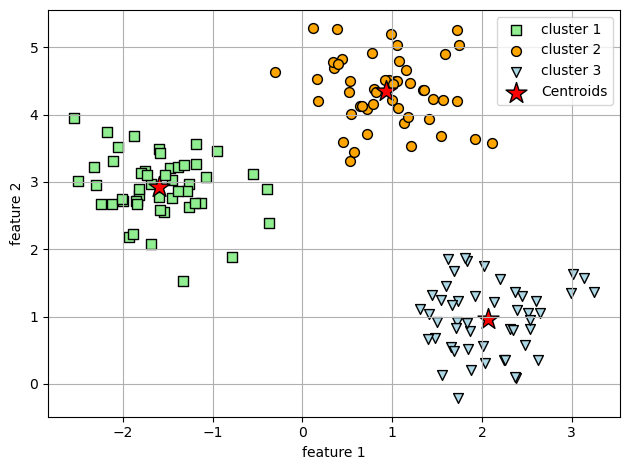

In [ ]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],s=50,c='lightgreen',marker='s',edgecolors='black',label="cluster 1")
plt.scatter(X[y_km==1,0],X[y_km==1,1],s=50,c='orange',marker='o',edgecolors='black',label="cluster 2")
plt.scatter(X[y_km==2,0],X[y_km==2,1],s=50,c='lightblue',marker='v',edgecolors='black',label="cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250,marker='*',c='red',edgecolors='black',label='Centroids')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

K-means worked well on this toy dataset, but we still have the drawback of having to specify the number of clusters $k$ a priori.

The other properties of k-means are:
- The clusters do not overlap;
- The clusters are not hierarchical;
- We also assume that there is at least one item in each cluster

## A smarter way of placing the initial cluster centroids using k-means++

Another strategy to place the initial random centroids is to place them far away from each other via the k-means++ algorithm, which leads to better and more consistent results that the classic k-means.

The initialization of k-means++ is as follows:
1. Initialize an empty set, $M$, to store the $k$ centroids being selected;
2. Randomly choose the first centroid, $\mu^{(j)}$, from the input examples and assign it to $M$;
3. For each example,$x^{(i)}$ , that is not in $M$, find the minimum squared distance, $d(x^{(i)},M)^2$, to any of the centroids in $M$;
4. To randomly select the next centroid, $\mu^{(p)}$, use a weighted probability distribution equal to $\frac{d(\mu^{(p)},M)^2}{\sum_i d(x^{(i)},M)^2}$. For instance, we collect all points in an array and choose a weighted random sampling, such that the larger the squared distance, the more likely a point gets chosen as the centroid;
5. Repeat steps 3 and 4 until $k$ centroids are chosen;
6. Proceed with the classic k-means algorithm.

In sklearn you just need to change the `init` parameter from `random` to `k-means++` (the default option, since it's highly suggested).

# Hard versus soft clustering

Hard clustering describes a family of algorithms where each example in a dataset is assigned to exactly one cluster, as in the k-means and k-means++ algorithms that we discussed earlier.

In contrast soft clustering (sometimes called fuzzy clustering) assign an example to one or more clusters. A popular example of this approach is the fuzzy C-means (FCM) algorithm.

The FCM procedure is pretty similar to k-means, however we replace the hard cluster assignment with probabilities for each point belonging to each cluster. The sum of the membership for a given example is equal to one.

We can summerize the FCM algorithm in four key steps:
1. Specify the number of $k$ centroids and randomly assign the cluster memberships for each point;
2. Compute the cluster centroids, $\mu^{(j)},j\in{1,...,k}$;
3. Update the cluster memberships for each point;
4. Repeat steps 2 and 3 until the membership coefficients do not change or a user-defined tolerance or maximum number of iterations is reached.

The objective function of FCM ($J_m$) looks very similar to the within-cluster SSE:
$$J_m=\sum_{i=1}^n\sum_{j=1}^kw^{(i,j)^m}\Vert x^{(i)}-\mu^{(j)}\Vert_2^2$$
However, note that the membership indicator, $w^{(i,j)}$, is not a binary value as in k-means, but a real value that denotes the cluster membership proability.

Also there is a new exponent $m$ to the $w$, which can be any number greater than or equal to one (typically=2), which is called fuzzifier and controls the degree of fuzziness. The larger the value of $m$, the smaller the cluster membership becomes, which leads to fuzzier clusters.

The cluster membership probability itself is calculated as follows:
$$w^{(i,j)}=[\sum_{c=1}^k\bigl(\frac{\Vert x^{(i)}-\mu^{(j)}\Vert_2}{\Vert x^{(i)}-\mu^{(c)}\Vert_2}\bigr)^{\frac{2}{m-1}}]^{-1}$$

Basically, if a point $i$ is strongly related to a cluster centroid $j$ its term of the summation will be closer to 1.

The other terms in the summation will be representing the distance between the point $i$ and the centroid $j$ weighted by the distance between the point $i$ and the other centroids $c\neq j$. If $i$ is weakly related to the other centroids, those term will result in little numbers (approaching 0).

In this case the summation will result in a number just a little bit greater than one, which means that the result inverted (due to the $-1$ in the exponent of the summation) will be closer to 1.

In the extreme opposite case, the result of the summation will be closer to 0.

> We can clearly see, just by looking at the equation to calculate the cluster memberships, that each iteration is more expensive compared to an iteration in k-means.

The center $\mu^{(j)}$ of a cluster itself is calculated (**it's not one of the points**) as the mean of all examples weighted by the degree to which each example belongs to the cluster ($w^{(i,j)^m}$):
$$\mu^{(j)}=\frac{\sum_{i=1}^nw^{(i,j)^m}x^{(i)}}{\sum_{i=1}^nw^{(i,j)^m}}$$

Scikit-learn does not implement the FCM algorithm, however scikit-fuzzy does (if you are interested int trying it out).

# Using the elbow method to find the optimal number of clusters

To quantify the quality of clustering, we need to use intrinsic metrics, such as the within-cluster SSE (also called distortion), to compare the performance of different k-means clustering models.

In [10]:
print(f"Distortion: {km.inertia_:.2f}")

Distortion: 72.48


Based on distortion we can use a graphical tool, the so-called elbow method, to estimate the optimal number of clusters, $k$, for a given task.

We can say that if $k$ increases, the distortion will decrease.

The idea behind the elbow method is to identify the value of $k$ where the distortion begins to increase most rapidly, which will become clearer if we plot the distortion for different values of $k$:

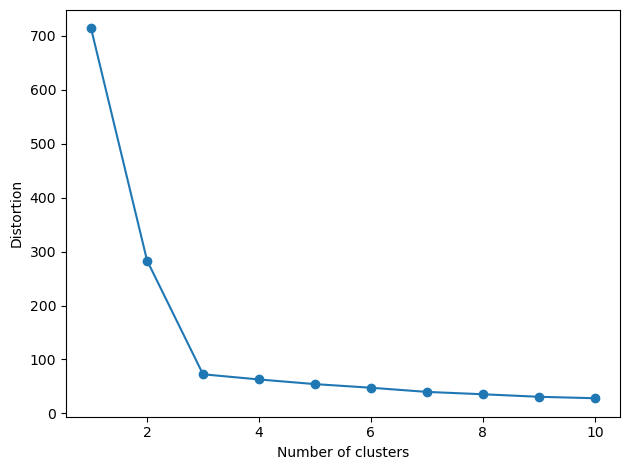

In [ ]:
distortions = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

Is clearly visible that $k=3$ is indeed a good choice for this dataset (is where the *elbow* is located).

## Quantify the quality of clustering via silhouette plots

Another intrinsic metric to evluate the quality of a clustering is *silhouette analysis*, which can also be applied to clustering algorithms other than k-means.

This tool can be used as a graphical tool to plot a measure of how tightly grouped the examples in the clusters are.

To calculate the slihouette coefficient of a single example in our dataset, we can apply the following steps:
1. Calculate the cluster cohesion, $a^{(i)}$, as the average distance between an example, $x^{(i)}$, and all other points in the same cluster;
2. Calculate the cluster separation, $b^{(i)}$, from the next closest cluster as the average distance between the example, $x^{(i)}$, and all examples in the nearest cluster;
3. Calculate the silhouette, $s^{(i)}$, as the difference between cluster cohesion and separation divided by the greater of the two:
$$s^{(i)}=\frac{b^{(i)}-a^{(i)}}{\max{\{b^{(i)},a^{(i)}}\}}$$

The silhouette coefficient is bounded in the range -1 to 1:
- 0 if the cluster separation and cohesion are equal;
- Approaching 1 if the $b^{(i)}>>a^{(i)}$ (meaning that the point doesn't belong to the right cluster, between the two used);
- Approaching -1 if the $b^{(i)}<<a^{(i)}$ (meaning that the point belongs to the right cluster, between the two used).

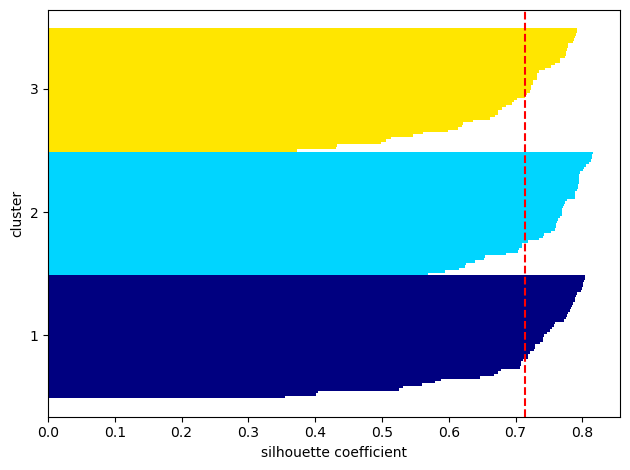

In [ ]:
km = KMeans(n_clusters=3,init='k-means++',n_init=10,max_iter=300,tol=1e-4,random_state=0)
y_km = km.fit_predict(X)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,height=1.0,edgecolor='none',color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle='--')
plt.yticks(yticks,cluster_labels+1)
plt.ylabel('cluster')
plt.xlabel('silhouette coefficient')
plt.tight_layout()
plt.show()

Remember that the silhouette coefficient goes from -1 to 1, so seeing that every datapoint has a silhouette coefficient greater than 0 is a good sign.

Another good sign is that the average silhouette coefficient approaches 1, suggesting that a good clustering model was used.

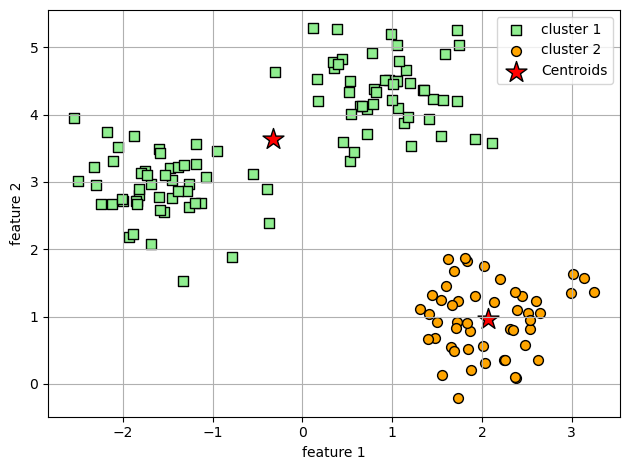

In [13]:
# Let's see a silhouette plot for a relatively bad clustering

km = KMeans(n_clusters=2,init='k-means++',n_init=10,max_iter=300,tol=1e-4,random_state=0)
y_km = km.fit_predict(X)
plt.scatter(X[y_km==0,0],X[y_km==0,1],s=50,c='lightgreen',marker='s',edgecolors='black',label="cluster 1")
plt.scatter(X[y_km==1,0],X[y_km==1,1],s=50,c='orange',marker='o',edgecolors='black',label="cluster 2")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=250,marker='*',c='red',edgecolors='black',label='Centroids')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()


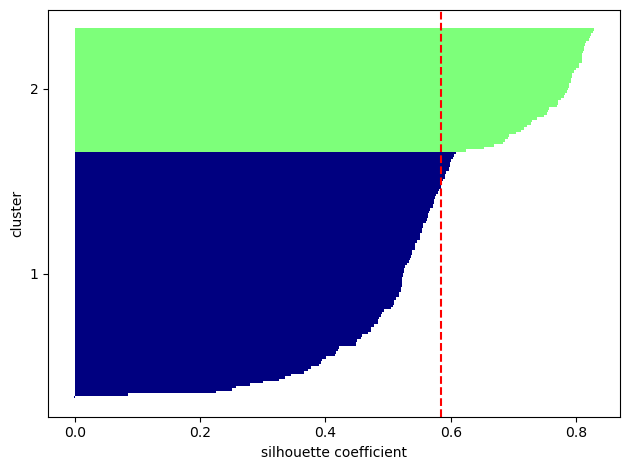

In [14]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i,c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,height=1.0,edgecolor='none',color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle='--')
plt.yticks(yticks,cluster_labels+1)
plt.ylabel('cluster')
plt.xlabel('silhouette coefficient')
plt.tight_layout()
plt.show()

# Organizing clusters as a hierarchical tree

One advantage of the hierarchical clustering algorithm is that it allows us to plot dendrograms (visualizations of a binary hierarchical clustering), which can help with the interpretation of the results.

Another advantage of this hierarchical approach is that we do not need to specify the number of clusters upfront.

The two main approaches to hierarchical clusstering are:
- **agglomerative**: we start with each example as an individual cluster and merge the closest pairs of clusters until only one cluster remains;
- **divisive**: we start with one cluster that encompasses the complete dataset, and we iteratively split the cluster into smaller clusters until each cluster only contains one example.

## Grouping clusters in a bottom-up fashion

The two standard algorithms for agglomerative hierarchical clustering are:
- single linkage: we compute the distances between the most similar members for each pair of clusters and merge the two clusters for which the distancebetween the most similar members is the smallest;
- complete linkage: here, instead of comparing the most similar members in each pair of clusters, we compare the most dissimilar members to perform the merge.

Hierarchical complete linkage clustering is an iterative procedure that can be summerized by the following steps:
1. Compute a pair-wise distance matrix of all examples;
2. Represent each data point as a singleton cluster;
3. Merge the two closest clusters based on the distance between the most dissimilar (distant members);
4. Update the cluster linkage matrix;
5. Repeat steps 2 to 4 until one single cluster remains.

In [15]:
# Let's firstly generate a random data sample to work with
import pandas as pd
import numpy as np
np.random.seed(123)
variables=['X','Y','Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables,index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [ ]:
# Let's calculate the distance matrix as input for the hierarchical clusterin algorithm
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df,metric='euclidean')),columns=labels,index=labels)
# pdist calculates the distance between each pair of the input examples (in a vector form)
# square form creates a symmetrical matrix of the pair-wise distances as shown here
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [ ]:
# Let's apply complete linkage agglomeration
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(df.values,method='complete',metric='euclidean')
pd.DataFrame(row_clusters,columns=['row label 1','row label 2','distance','no. of items in clust.'], index=[f"cluster {(i+1)}" for i in range(row_clusters.shape[0])])
# Here the row label refers to the number of the clusters (the first original 5 + the ones created during the process)

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


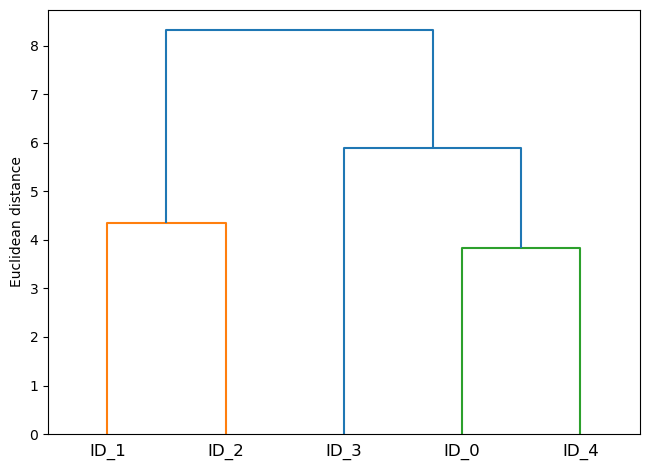

In [18]:
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters,labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# Applying agglomerative clustering via scikit-learn

The scikit-learn version of hierarchical clustering allows us to prune the hiearchical clustering tree.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="complete")
labels=ac.fit_predict(X)
print(f'cluster_labels: {labels}')

cluster_labels: [1 0 0 2 1]


This has to be read as: "The first and the last points are in cluster one; the second and the third is in cluster 0; the fourth is in cluster 2".

In [ ]:
# Let's now use 2 clusters
ac = AgglomerativeClustering(n_clusters=2, metric="euclidean", linkage="complete")
labels=ac.fit_predict(X)
print(f'cluster_labels: {labels}')
# As we can see the third data point was assigned the same cluster of the first and the last points, as expected

cluster_labels: [0 1 1 0 0]


# Locating regions of high density via DBSCAN

DBSCAN is a density based spatial clustering of applications with noise, which does not make assumptions about spherical clusters like k-means, nor does it partition the dataset into hierarchies that require a manual cut-off point.

Density based clustering assignis cluster labels based on dense regions of points.

In DBSCAN the notion of density is defined as the number of points within a specified radius $\epsilon$.

According to the DBSCAN algorithm, a special label is assigned to each example (data point) using the following criteria:
- A point is considere a core point if at least a specified number (MinPts) of neighbouring points fall within the specified radius $\epsilon$;
- A border point is a point that has fewer neighbors than MinPts within $\epsilon$, but lies within the $\epsilon$ radius of a core point;
- All other points that are neither core nor border points are considered noise points.

After labelling the points as core, border or noise the DBSCAN algorithm can be summerized in two simple steps:
1. Forma a separate cluster for each core point or connected group of core points (core points are connected if they are no father away than $\epsilon$);
2. Assign each border point to the cluster of its corresponding core point.

One of the main advantages is that it does not assume that the clusters have a spherical shape as in k-means, and it doesn't necessarily assign each point to a cluster but is capable of removing noise points.

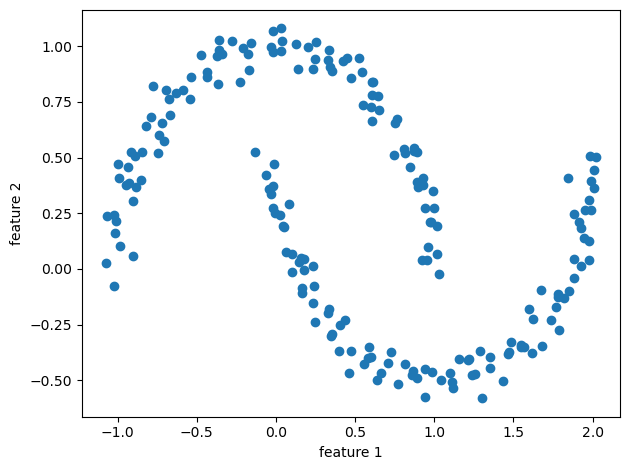

In [38]:
from sklearn.datasets import make_moons

X,y= make_moons(n_samples=200,noise=0.05,random_state=0)
plt.scatter(X[:,0],X[:,1])
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.tight_layout()
plt.show()

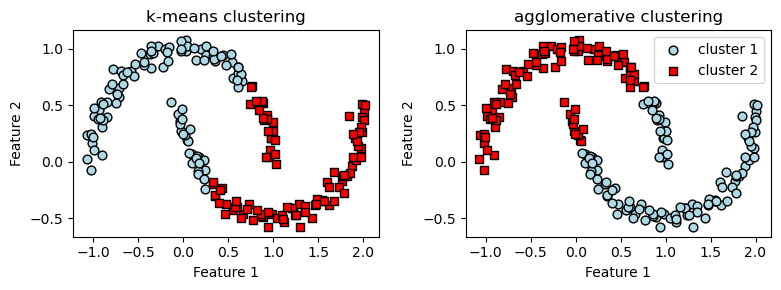

In [42]:
# Let's firstly use k-means and complete linkage to see if they are able to successfully identify the half-moon shapes.
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
km = KMeans(n_clusters=2,random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0,0],X[y_km == 0,1],c="lightblue",edgecolor="black",marker="o",s=40,label='cluster 1')
ax1.scatter(X[y_km == 1,0],X[y_km == 1,1],c="red",edgecolor="black",marker="s",s=40,label='cluster 2')
ax1.set_title("k-means clustering")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

ac = AgglomerativeClustering(n_clusters=2,linkage='complete',metric='euclidean')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0,0],X[y_ac == 0,1],c="lightblue",edgecolor="black",marker="o",s=40,label='cluster 1')
ax2.scatter(X[y_ac == 1,0],X[y_ac == 1,1],c="red",edgecolor="black",marker="s",s=40,label='cluster 2')
ax2.set_title("agglomerative clustering")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")

plt.legend()
plt.tight_layout()
plt.show()
# We can clearly see that these algorithms are pretty challenged by these complex shapesjj

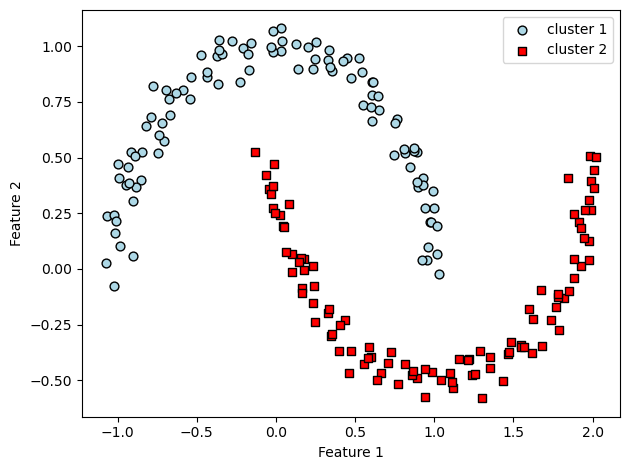

In [44]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2,min_samples=5,metric='euclidean')
y_db = db.fit_predict(X)

plt.scatter(X[y_db == 0,0],X[y_db == 0,1],c="lightblue",edgecolor="black",marker="o",s=40,label='cluster 1')
plt.scatter(X[y_db == 1,0],X[y_db == 1,1],c="red",edgecolor="black",marker="s",s=40,label='cluster 2')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.legend()
plt.tight_layout()
plt.show()

The DBSCAN algorithm can succesfully detect the half-moon shapes, which highlights one of its strenghts (clustering data of arbitrary shapes).

We also note that with an increasing number of features in our dataset (assuming a fixed number of training examples), the negative effect of the **curse of dimensionality** increases, especially if we are using the euclidean distance. However this is a common problem for every clustering algorithm that relies on the euclidean distance metric.
In addition to this though, we have two hyper parameters in DBSCAN (MinPts and $\epsilon$) that need to be optimized to yield good clustering results.

> OFF-TOPIC: another prominent clustering technique is the spectral clustering. Basically using eigen-vectors of a similarity or distance matrix, to use a clustering technique (i.e. k-means) in a space of reduced dimensionality.

Best practices before clustering analysis are:
- Not only depend on the algorithm and its hyperparameters, but rather the choice of an appropriate distance metric and the use of domain knowledge that can help to guide the experimental setup;
- In the context of curse dimensionality, it is thus common practice to apply dimensionality reduction techniques prior to performing clustering;
- It is particularly common to compress datasets down to two-dimensional subspaces, which allows us to visualize the clusters and assigned labels using two-dimensional scatterplots, which are particularly helpful for evaluating the results.